# Stock Price Predication via Sentiment Analysis on Wallstreetbets
## Import packages
- scikit-learn
- Yahoo finance
- VADER sentiment analysis

In [1]:
import pandas as pd
import re
import nltk
import yfinance as yf
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy as np
import statsmodels.api as sm

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from plot_metric.functions import BinaryClassification
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Daolin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data pre-processing

In [3]:
# Read the input file
dataset = pd.read_csv('reddit_wsb_updated.csv')

In [4]:
# Create timestamp for the dataframe
title_data = dataset[['title','timestamp']].copy()
body_data  = dataset[['body','timestamp']].copy()
body_data  = body_data.dropna()
title_data = title_data.dropna()

# Change all character to lower cases
title_data.title = title_data.title.str.lower()
body_data.body   = body_data.body.str.lower()

# Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove any special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

# Remove any single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# Remove Time from Timestamp, keep the date
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp  = pd.to_datetime(body_data.timestamp).dt.date
body_data.head()

,body,timestamp
0,cbat is going to begreat play further yet thei...,2020-09-29
3,you guys are amazing thank you for sending gme...,2021-01-28
4,will update daily at market close top 5 securi...,2021-01-28
5,hey retards what the hell is going on with amc...,2021-01-28
6,i cansee how to talk to to any anti bot measur...,2021-01-28


In [5]:
# Get Sentiment Score for post title
sid = SIA()

title_data['sentiments']           = title_data['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data['Positive Sentiment']   = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data['Neutral Sentiment']    = title_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data['Negative Sentiment']   = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
title_data['Compound Score']       = title_data['sentiments'].apply(lambda x: x['compound']+1*(10**-6))

title_data.drop(columns=['sentiments'],inplace=True)
title_data.head()

,title,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Score
0,cbat sunw spi oxbrall are missing the point,2020-09-29,0.000001,0.761001,0.239001,-0.295999
1,an autists journey 150 to 68k in one month sto...,2021-01-28,0.000001,1.000001,0.000001,0.000001
2,you all have made melvin live up to its name,2021-01-28,0.000001,1.000001,0.000001,0.000001
3,i got in late on gme butbelieve in the cause a...,2021-01-28,0.000001,0.847001,0.153001,-0.401899
4,highest si of float end of business jan 27th a...,2021-01-28,0.000001,1.000001,0.000001,0.000001


## Sentiment anlysis

In [6]:
# Get Sentiment Score for post body
sid = SIA()

body_data['sentiments']           = body_data['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
body_data['Positive Sentiment']   = body_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
body_data['Neutral Sentiment']    = body_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
body_data['Negative Sentiment']   = body_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
body_data['Compound Score']       = body_data['sentiments'].apply(lambda x: x['compound']+1*(10**-6))

body_data.drop(columns=['sentiments'],inplace=True)
body_data.head(5)

,body,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Score
0,cbat is going to begreat play further yet thei...,2020-09-29,0.143001,0.841001,0.016001,0.893401
3,you guys are amazing thank you for sending gme...,2021-01-28,0.119001,0.830001,0.051001,0.557401
4,will update daily at market close top 5 securi...,2021-01-28,0.089001,0.911001,0.000001,0.458801
5,hey retards what the hell is going on with amc...,2021-01-28,0.000001,0.850001,0.150001,-0.680799
6,i cansee how to talk to to any anti bot measur...,2021-01-28,0.177001,0.690001,0.132001,0.376001


In [7]:
# Creating class from sentiment values for post title
title_data['class_name'] = title_data[['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']].idxmax(axis=1)
data1 = title_data
data1.head(5)

,title,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Score,class_name
0,cbat sunw spi oxbrall are missing the point,2020-09-29,0.000001,0.761001,0.239001,-0.295999,Neutral Sentiment
1,an autists journey 150 to 68k in one month sto...,2021-01-28,0.000001,1.000001,0.000001,0.000001,Neutral Sentiment
2,you all have made melvin live up to its name,2021-01-28,0.000001,1.000001,0.000001,0.000001,Neutral Sentiment
3,i got in late on gme butbelieve in the cause a...,2021-01-28,0.000001,0.847001,0.153001,-0.401899,Neutral Sentiment
4,highest si of float end of business jan 27th a...,2021-01-28,0.000001,1.000001,0.000001,0.000001,Neutral Sentiment


In [8]:
# Creating class from sentiment values for post body
body_data['class_name'] = body_data[['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']].idxmax(axis=1)
data2 = body_data
data2.head(5)

,body,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Score,class_name
0,cbat is going to begreat play further yet thei...,2020-09-29,0.143001,0.841001,0.016001,0.893401,Neutral Sentiment
3,you guys are amazing thank you for sending gme...,2021-01-28,0.119001,0.830001,0.051001,0.557401,Neutral Sentiment
4,will update daily at market close top 5 securi...,2021-01-28,0.089001,0.911001,0.000001,0.458801,Neutral Sentiment
5,hey retards what the hell is going on with amc...,2021-01-28,0.000001,0.850001,0.150001,-0.680799,Neutral Sentiment
6,i cansee how to talk to to any anti bot measur...,2021-01-28,0.177001,0.690001,0.132001,0.376001,Neutral Sentiment


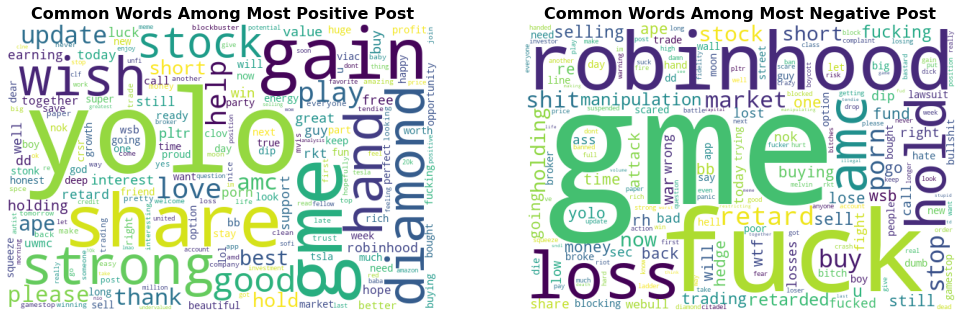

In [9]:
# wordcloud for most common words in postive and negative in post title
Most_Positive = title_data[title_data['Positive Sentiment'].between(0.4,1)]['title']
Most_Negative = title_data[title_data['Negative Sentiment'].between(0.25,1)]['title']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)

pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)

# Figure propeties
plt.rc('figure',figsize=(17,13))
plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Post',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Post',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')
plt.show()

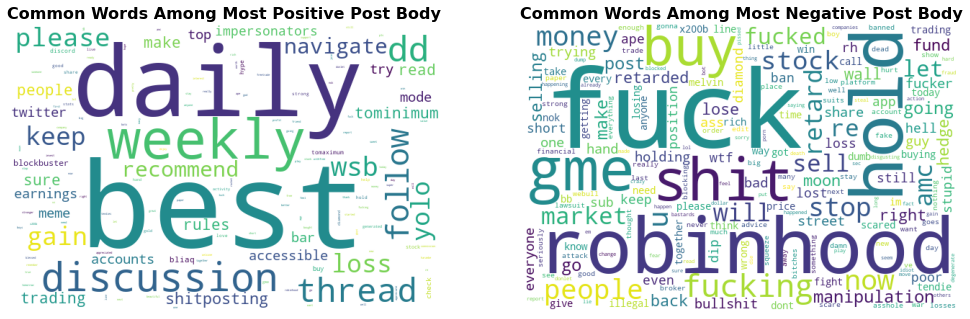

In [10]:
# wordcloud for most common words in postive and negative in post body
Most_Positive = body_data[body_data['Positive Sentiment'].between(0.4,1)]['body']
Most_Negative = body_data[body_data['Negative Sentiment'].between(0.25,1)]['body']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)

pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)

# Figure propeties
plt.rc('figure',figsize=(17,13))
plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Post Body',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Post Body',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')
plt.show()

## Get market data

In [11]:
# Load the market data from Yahoo finance
start = datetime.date(2021,1,23)
end = datetime.date(2021,8,16)
gme = web.DataReader('GME','yahoo',start,end)

In [12]:
gme.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-22,76.760002,42.320000,42.590000,65.010002,197157900,65.010002
2021-01-25,159.179993,61.130001,96.730003,76.790001,177874000,76.790001
2021-01-26,150.000000,80.199997,88.559998,147.979996,178588000,147.979996
2021-01-27,380.000000,249.000000,354.829987,347.510010,93396700,347.510010
2021-01-28,483.000000,112.250000,265.000000,193.600006,58815800,193.600006


In [13]:
# Create a new dataframe and set new index
df = gme['Adj Close'].pct_change()*100
df = df.rename('Today')
df = df.reset_index()

In [14]:
# Creating lags for adj close price
for i in range(1,4):
    df['Lag '+str(i)] = df['Today'].shift(i)

In [15]:
# Drop null values 
df['Volume'] = gme.Volume.shift(1).values/1000_000_000
df = df.dropna()

In [16]:
# Set Up indicator
df['Up'] = [1 if i > 0 else 0 for i in df['Today']]

In [17]:
df

,Date,Today,Lag 1,Lag 2,Lag 3,Volume,Up
4,2021-01-28,-44.289373,134.835802,92.707376,18.120287,0.093397,0
5,2021-01-29,67.871896,-44.289373,134.835802,92.707376,0.058816,1
6,2021-02-01,-30.769231,67.871896,-44.289373,134.835802,0.050566,0
7,2021-02-02,-60.000000,-30.769231,67.871896,-44.289373,0.037382,0
8,2021-02-03,2.677782,-60.000000,-30.769231,67.871896,0.078183,1
...,...,...,...,...,...,...,...
138,2021-08-10,-1.290884,6.167227,-1.088372,4.523160,0.002249,0
139,2021-08-11,-0.169761,-1.290884,6.167227,-1.088372,0.001623,0
140,2021-08-12,2.248399,-0.169761,-1.290884,6.167227,0.000945,1
141,2021-08-13,0.104711,2.248399,-0.169761,-1.290884,0.001318,1


In [18]:
# Merge the Sentiment analysis and marktet data 
df.rename(columns={'Date':'timestamp'}, inplace=True)
df.timestamp = pd.to_datetime(df.timestamp).dt.date
data3 = df.merge(data1, how = 'outer', on='timestamp')

In [19]:
# Drop row wil Null value
data3 = data3[pd.notnull(data3['Lag 3'])]

In [20]:
# Get the daily avrege Sentiment Score 
data3 = data3.groupby(["timestamp"]).mean()

In [21]:
# Add constant 1 to the dataframe and drop any Null value
data3['const'] = 1
data4 = data3[pd.notnull(data3['Compound Score'])]

In [22]:
# Drop unused columns
data4 = data4.drop(columns='Volume')
data4 = data4.drop(columns='Positive Sentiment')
data4 = data4.drop(columns='Neutral Sentiment')
data4 = data4.drop(columns='Negative Sentiment')

In [23]:
data4

,Today,Lag 1,Lag 2,Lag 3,Up,Compound Score,const
timestamp,,,,,,,
2021-01-28,-44.289373,134.835802,92.707376,18.120287,0.0,-0.010775,1
2021-01-29,67.871896,-44.289373,134.835802,92.707376,1.0,-0.016905,1
2021-02-01,-30.769231,67.871896,-44.289373,134.835802,0.0,0.028891,1
2021-02-02,-60.000000,-30.769231,67.871896,-44.289373,0.0,0.016466,1
2021-02-03,2.677782,-60.000000,-30.769231,67.871896,1.0,0.020373,1
...,...,...,...,...,...,...,...
2021-08-10,-1.290884,6.167227,-1.088372,4.523160,0.0,0.087403,1
2021-08-11,-0.169761,-1.290884,6.167227,-1.088372,0.0,0.113782,1
2021-08-12,2.248399,-0.169761,-1.290884,6.167227,1.0,0.084200,1


In [24]:
x = data4[['const', 'Lag 1', 'Lag 2', 'Lag 3', 'Compound Score']]

In [25]:
y = data4.Up

In [26]:
## Confusion matrix(Random Forest and Logistic Regression)

In [27]:
# Split the dataset into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 7)

In [28]:
# Random Forest model,
model = RandomForestClassifier(n_estimators = 25 , max_depth=9)
result = model.fit(X_train,y_train)
prediction = result.predict(X_test)

In [29]:
confusion_matrix(y_test, prediction)

array([[14, 11],
       [ 2,  8]], dtype=int64)

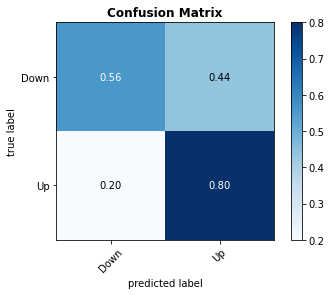

In [30]:
# Plot the confusion matrix
matrix = np.array(confusion_matrix(y_test,prediction))
classes = ['Down', 'Up']
plt.rc('figure',figsize=(6,4))
figure, ax = plot_confusion_matrix(conf_mat = matrix,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)
plt.title('Confusion Matrix',fontsize = 12,fontweight = 'bold')
plt.show()

In [31]:
# Logistic Regression model
model2 = LogisticRegression(C = 1, max_iter = 100000, penalty='l2')
result2 = model2.fit(X_train,y_train)
prediction2 = result2.predict(X_test)
confusion_matrix(y_test, prediction)

array([[14, 11],
       [ 2,  8]], dtype=int64)

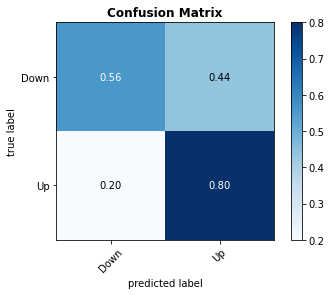

In [32]:
# Plot the confusion matrix
matrix = np.array(confusion_matrix(y_test,prediction))
classes = ['Down', 'Up']
plt.rc('figure',figsize=(6,4))
figure, ax = plot_confusion_matrix(conf_mat = matrix,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)
plt.title('Confusion Matrix',fontsize = 12,fontweight = 'bold')
plt.show()

## Grid search to find best score and parameters

In [33]:
# Set grid search parameters
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [5, 10, 25, 40],
            'max_depth': [3, 6, 9, 15]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1, 5, 15],
            'max_iter': [100000],
            'penalty': ['l1', 'l2'],
        }
    }
}

In [34]:
# Get grid search best scores and parameters
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=4, return_train_score=False)
    clf.fit(x, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,random_forest,0.611345,"{'max_depth': 6, 'n_estimators': 25}"
1,logistic_regression,0.611134,"{'C': 1, 'max_iter': 100000, 'penalty': 'l2'}"


## Traditional stocks vs MEME stocks

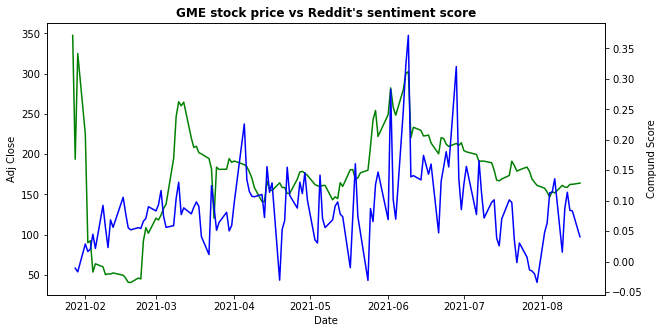

In [35]:
# Graphs for comparing stock price and Reddit's setiment
# Input data
start = datetime.date(2021,1,28)
end = datetime.date(2021,8,16)
GME = web.DataReader('GME','yahoo',start,end).reset_index()
Score = data3.reset_index()
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# ignore scientific notation and show plain numbers on axis
ax2.ticklabel_format(style='plain')
# plotting Date and AdjClose on first y axis
ax1.plot(GME['Date'], GME['Adj Close'],'g-')
# plotting Date and Adj Close on second y axis
ax2.plot(Score['timestamp'], Score['Compound Score'],'b-')

# set labels to axis and finally show the plot
ax1.set_xlabel('Date')
ax1.set_ylabel('Adj Close')
ax2.set_ylabel('Compund Score')
plt.title("GME stock price vs Reddit's sentiment score",fontsize = 12,fontweight = 'bold')
plt.show()

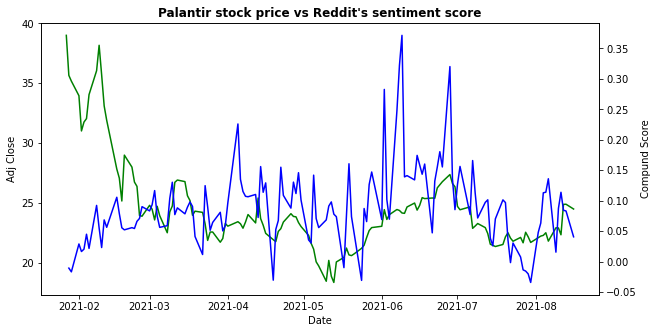

In [36]:
# Input data
start = datetime.date(2021,1,28)
end = datetime.date(2021,8,16)
GME = web.DataReader('PLTR','yahoo',start,end).reset_index()
Score = data3.reset_index()
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# ignore scientific notation and show plain numbers on axis
ax2.ticklabel_format(style='plain')
# plotting Date and AdjClose on first y axis
ax1.plot(GME['Date'], GME['Adj Close'],'g-')
# plotting Date and Adj Close on second y axis
ax2.plot(Score['timestamp'], Score['Compound Score'],'b-')

# set labels to axis and finally show the plot
ax1.set_xlabel('Date')
ax1.set_ylabel('Adj Close')
ax2.set_ylabel('Compund Score')
plt.title("Palantir stock price vs Reddit's sentiment score",fontsize = 12,fontweight = 'bold')
plt.show()

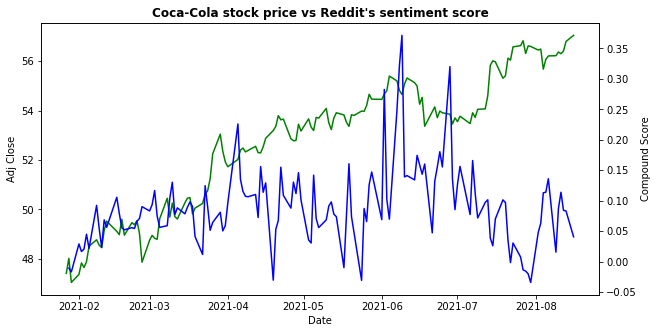

In [37]:
start = datetime.date(2021,1,28)
end = datetime.date(2021,8,16)
SPY = web.DataReader('KO','yahoo',start,end).reset_index()
Score = data3.reset_index()
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# ignore scientific notation and show plain numbers on volume axis
ax2.ticklabel_format(style='plain')
# plotting Date and AdjClose on first y axis
ax1.plot(SPY['Date'], SPY['Adj Close'],'g-')

# plotting Date and Adj Close on second y axis
ax2.plot(Score['timestamp'], Score['Compound Score'],'b-')

# set labels to axis and finally show the plot
ax1.set_xlabel('Date')
ax1.set_ylabel('Adj Close')
ax2.set_ylabel('Compound Score')
plt.title("Coca-Cola stock price vs Reddit's sentiment score",fontsize = 12,fontweight = 'bold')
plt.show()